In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from collections import defaultdict
import os

In [2]:
def to_paper_name(algo: str):
    if algo.startswith("sf_reinforce"):
        return algo.replace("sf_reinforce", "SFR1")
    if algo.startswith("two_sided_sf_reinforce"):
        return algo.replace("two_sided_sf_reinforce", "SFR2")
    return algo

In [3]:
def show_weights(filename):
    vals = {}
    actions = 'up right down left'.split()
    with open(filename, 'rb') as file:
        state_dict = torch.load(file, map_location=torch.device("cpu"))
    for key, value in state_dict.items():
        # vals[key+".max"] = value.max().item()
        # vals[key+".min"] = value.min().item()
        for act, row in zip(actions, value.numpy().round(2)):
            vals[f"{key}.{act}"] = row
    return vals

def get_results(filename, rolling_len=200):
    with open(filename, "rb") as file:
        results = pickle.load(file)
    if len(results[0]) < 5000:
        new_results = []
        for row in results:
            new_results.append([])
            for item in row:
                new_results[-1].extend([item]*100)

        # truncate to nearest multiple of 10k
        n = len(new_results[0])
        n = (n // 10000) * 10000
        results = [row[:n] for row in new_results]
    dirname = os.path.dirname(filename)
    rolled_up = []
    frame = []
    for seed, result in enumerate(results):
        r = pd.Series(result).rolling(rolling_len, min_periods=1).mean().dropna()
        r = list(r)
        rolled_up.append(r)
        weights_file = os.path.join(dirname, f"weights.{seed}.pth")
        vals = show_weights(weights_file)
        vals["perf"] = r[-1]
        frame.append(vals)
    frame = pd.DataFrame.from_records(frame)
    # display(frame.sort_values("perf", ascending=False))
    rolled_up = np.array(rolled_up)

    avg_rewards = np.median(rolled_up, 0)
    min_rewards = rolled_up.min(0)
    max_rewards = rolled_up.max(0)
    std_rewards = rolled_up.std(0)

    bot = np.maximum(avg_rewards - std_rewards, min_rewards)
    top = np.minimum(avg_rewards + std_rewards, max_rewards)
    return avg_rewards, bot, top


In [4]:
# vals = defaultdict(int)
# for seed in range(10):
#     # print(seed)
#     with open(f"saves/reinforce/tiny/weights.{seed}.pth", 'rb') as file:
#         state_dict = torch.load(file, map_location=torch.device("cpu"))
#     for key, value in state_dict.items():
#         # print("\t", key, value.max(), value.min())
#         vals[key+".max"] = max(vals[key+".max"], value.max().item())
#         vals[key+".min"] = min(vals[key+".min"], value.min().item())

# print("Reinforce")
# for key, value in vals.items():
#     print(key, value)


In [5]:
# vals = defaultdict(int)
# for seed in range(10):
#     # print(seed)
#     with open(f"saves/sf_reinforce/tiny/weights.{seed}.pth", 'rb') as file:
#         state_dict = torch.load(file, map_location=torch.device("cpu"))
#     for key, value in state_dict.items():
#         vals[key+".max"] = max(vals[key+".max"], value.max().item())
#         vals[key+".min"] = min(vals[key+".min"], value.min().item())

# print("SPSA")
# for key, value in vals.items():
#     print(key, value)


## Other plots

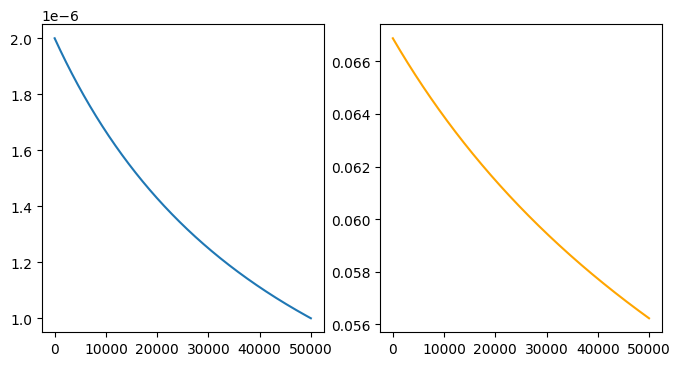

In [6]:
def get_delta(episode):
    return (2e-5 / (1 + episode * 2e-5)) ** 0.25


def get_alpha(episode):
    return 2e-6 / (1 + episode * 2e-5)


episode = np.arange(50000)
alpha = get_alpha(episode)
delta = get_delta(episode)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(episode, alpha)
ax[1].plot(episode, delta, color="orange")


## Gridsizes

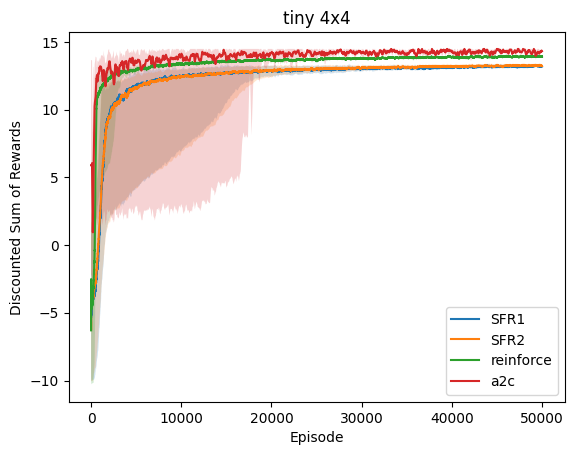

In [7]:
gridsizes = ["4x4"]
for grid, gridsize in zip(["tiny"], gridsizes):
    for algo in "sf_reinforce two_sided_sf_reinforce reinforce a2c".split():
        dirname = os.path.join("saves", algo, grid)
        filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
        path = os.path.join(dirname, filename)
        avg_rewards, bot, top = get_results(path)
        plt.plot(avg_rewards, label=to_paper_name(algo))
        plt.fill_between(range(len(avg_rewards)), bot, top, alpha=0.2)
    plt.title(f"{grid} {gridsize}")
    plt.xlabel('Episode')
    plt.ylabel('Discounted Sum of Rewards')
    plt.legend()
    plt.show()

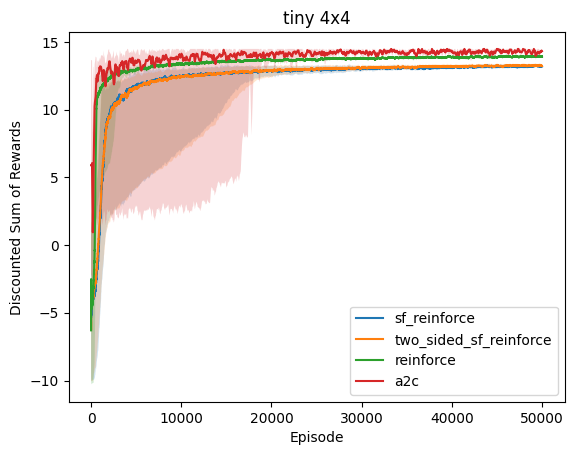

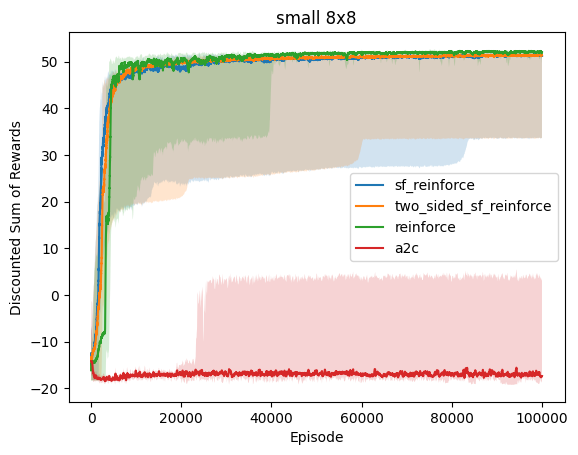

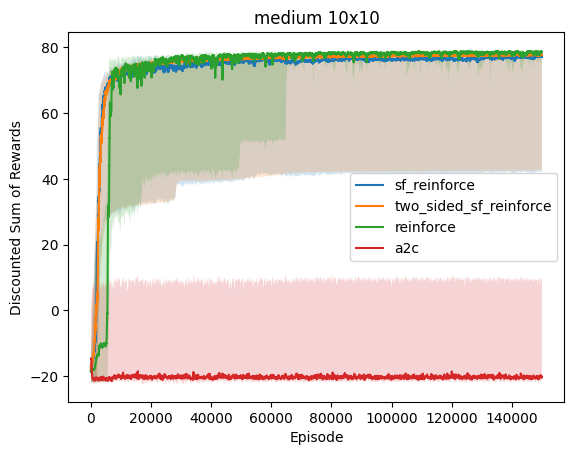

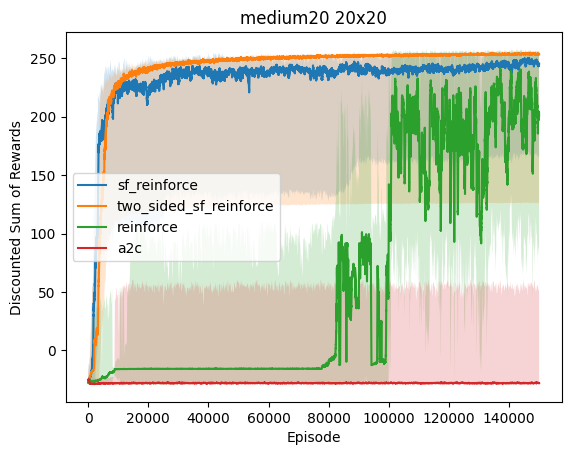

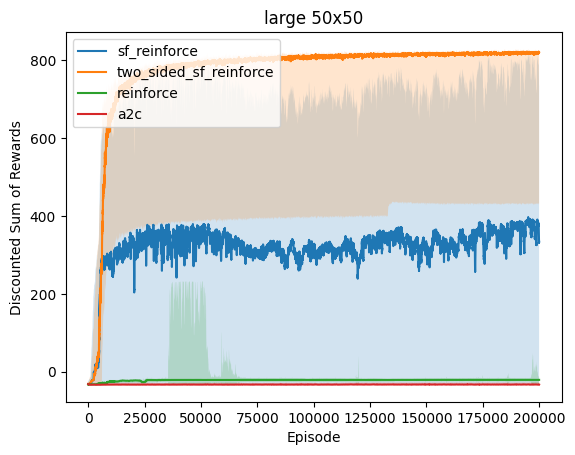

In [8]:
gridsizes = ["4x4", "8x8", "10x10", "20x20", "50x50"]
for grid, gridsize in zip("tiny small medium medium20 large".split(), gridsizes):
    for algo in "sf_reinforce two_sided_sf_reinforce reinforce a2c".split():
        dirname = os.path.join("saves", algo, grid)
        filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
        path = os.path.join(dirname, filename)
        avg_rewards, bot, top = get_results(path)
        plt.plot(avg_rewards, label=algo)
        plt.fill_between(range(len(avg_rewards)), bot, top, alpha=0.2)
    plt.title(f"{grid} {gridsize}")
    plt.xlabel('Episode')
    plt.ylabel('Discounted Sum of Rewards')
    plt.legend()
    plt.savefig(f"images/{grid}.png", bbox_inches="tight")
    plt.show()


## Perturbation Sizes

### Medium Gridsize

sf_reinforce_0.101 medium
two_sided_sf_reinforce_0.101 medium


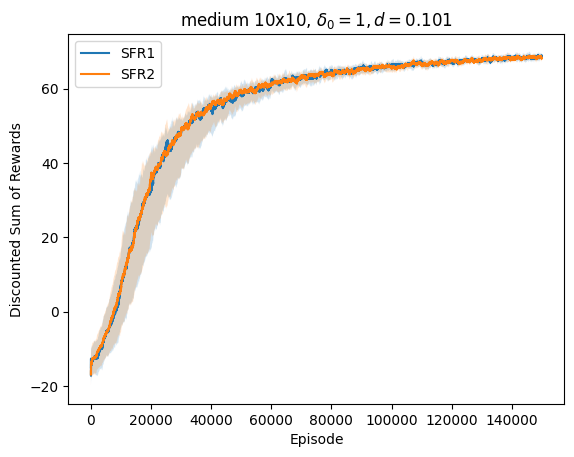

sf_reinforce_0.15 medium
two_sided_sf_reinforce_0.15 medium


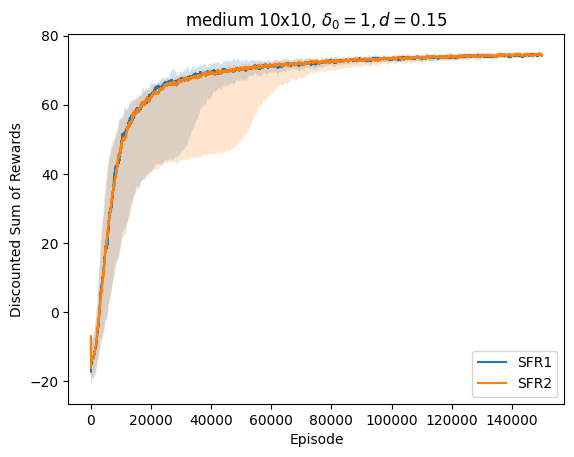

sf_reinforce_0.25 medium
two_sided_sf_reinforce_0.25 medium


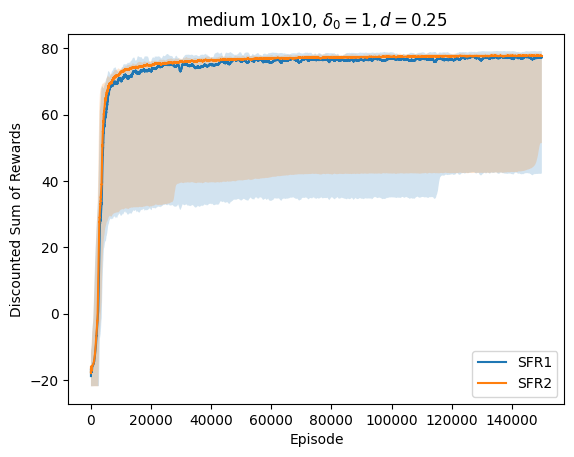

sf_reinforce_0.35 medium
two_sided_sf_reinforce_0.35 medium


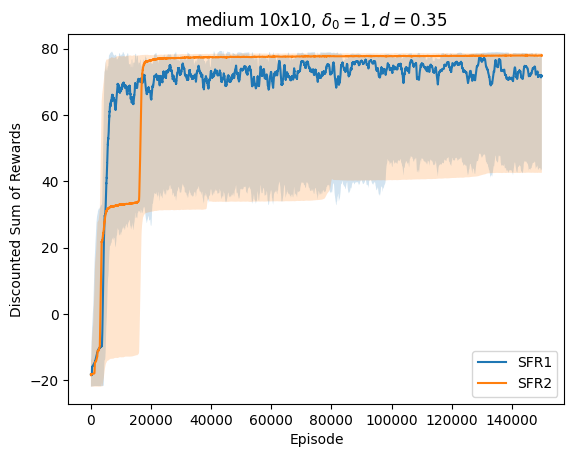

sf_reinforce_0.45 medium
two_sided_sf_reinforce_0.45 medium


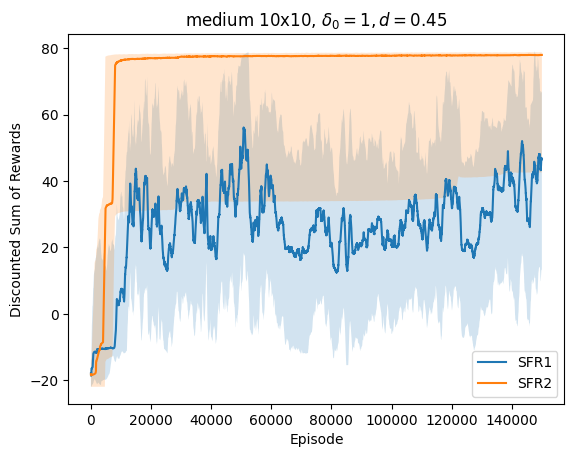

sf_reinforce_const_0.175 medium
two_sided_sf_reinforce_const_0.175 medium


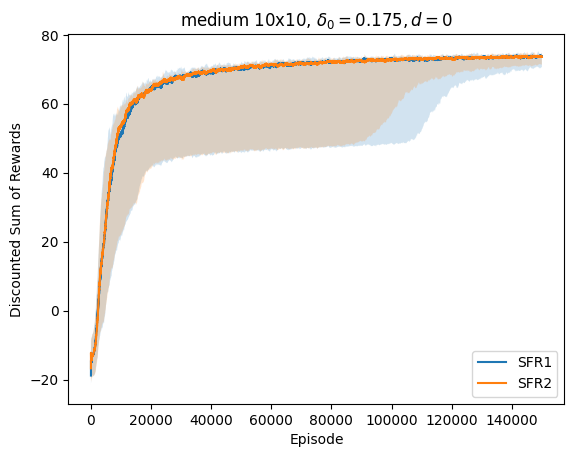

sf_reinforce_const_0.5 medium
two_sided_sf_reinforce_const_0.5 medium


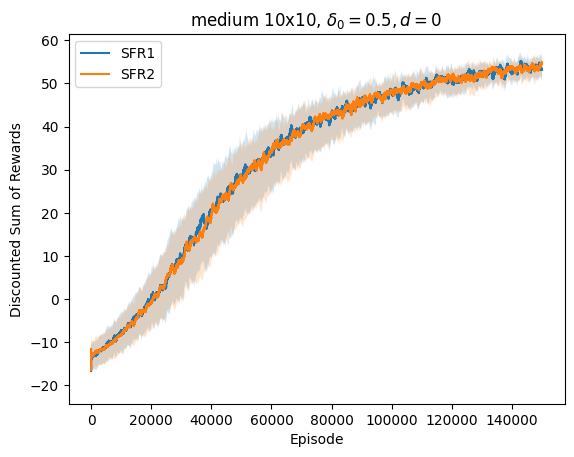

In [12]:
gridsizes = ["4x4", "8x8", "10x10", "20x20", "50x50"]
for grid, gridsize in zip(["medium"], ["10x10"]):
    for suffix in "0.101 0.15 0.25 0.35 0.45 const_0.175 const_0.5".split():
        for algo in "sf_reinforce two_sided_sf_reinforce".split():
            name = algo + "_" + suffix
            dirname = os.path.join("saves", name, grid)
            filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
            path = os.path.join(dirname, filename)
            print(name, grid)
            avg_rewards, bot, top = get_results(path, 800)
            plt.plot(avg_rewards, label=to_paper_name(algo))
            plt.fill_between(range(len(avg_rewards)), bot, top, alpha=0.2)
        # plt.plot([80] * len(avg_rewards), label="bound")
        if suffix.startswith('const'):
            plt.title(f"{grid} {gridsize}, $\delta_0={suffix[6:]}, d=0$")
        else:
            plt.title(f"{grid} {gridsize}, $\delta_0=1, d={suffix}$")
        plt.xlabel('Episode')
        plt.ylabel('Discounted Sum of Rewards')
        plt.legend()
        if 'const' not in suffix:
            plt.savefig(f"images/sfr{suffix}.png", bbox_inches="tight")
        else:
            plt.savefig(f"images/sfr_{suffix}.png", bbox_inches="tight")
        plt.show()


In [13]:
# from spsa import get_delta

# for delta_pow in np.arange(0.15, 0.5, 0.1):
#     ep = np.arange(150000)
#     delta = get_delta(ep, delta_pow, None)
#     print(delta_pow, delta.mean())
#     plt.plot(ep, delta, label="exp="+str(round(delta_pow, 2)))

# # for const_delta in [0.175, 0.5]:
# #     ep = np.arange(150000)
# #     delta = np.ones_like(ep) * const_delta
# #     plt.plot(ep, delta, label="const_delta="+str(round(const_delta, 3)))

# plt.legend();
# plt.title("Different exp-decay schemes for delta")


### Tables

In [12]:
# table for experiment 1 different sizes, different algorithm
frame = []
gridsizes = ["4x4", "8x8", "10x10", "20x20", "50x50"]
for algo in "reinforce ppo sf_reinforce two_sided_sf_reinforce".split():
    for grid, gridsize in zip("tiny small medium medium20 large".split(), gridsizes):
        dirname = os.path.join("saves", algo, grid)
        filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
        path = os.path.join(dirname, filename)
        with open(path, "rb") as file:
            results = np.array(pickle.load(file))

        per_seed_results = results[:, -200:].mean(1)
        disp = f"{per_seed_results.mean():.2f} +- {per_seed_results.std():.1f}"
        frame.append((algo, gridsize, disp))
frame = pd.DataFrame(frame).pivot(index=0, columns=1).reset_index()
frame.columns = ["Algorithm / Gridsize"] + [col for _, col in frame.columns][1:]
frame = frame[["Algorithm / Gridsize"] + gridsizes]
display(frame)
print(
    frame
    .to_latex(index=False, escape=True)
    .replace("toprule", "hline")
    .replace("bottomrule", "hline")
    .replace("midrule", "hline")
    .replace("+-", "$\\pm$")
)


,Algorithm / Gridsize,4x4,8x8,10x10,20x20,50x50
0,ppo,-1.08 +- 2.0,-11.13 +- 1.8,-14.79 +- 2.4,-27.27 +- 4.7,-41.83 +- 2.0
1,reinforce,13.90 +- 0.1,50.74 +- 2.3,76.90 +- 4.9,144.89 +- 113.8,-18.79 +- 8.4
2,sf_reinforce,13.23 +- 0.1,45.40 +- 17.7,59.80 +- 35.0,220.24 +- 78.8,376.29 +- 401.4
3,two_sided_sf_reinforce,13.26 +- 0.1,45.52 +- 17.8,60.39 +- 35.0,170.68 +- 127.4,562.89 +- 387.7


\begin{tabular}{llllll}
\hline
Algorithm / Gridsize & 4x4 & 8x8 & 10x10 & 20x20 & 50x50 \\
\hline
ppo & -1.08 $\pm$ 2.0 & -11.13 $\pm$ 1.8 & -14.79 $\pm$ 2.4 & -27.27 $\pm$ 4.7 & -41.83 $\pm$ 2.0 \\
reinforce & 13.90 $\pm$ 0.1 & 50.74 $\pm$ 2.3 & 76.90 $\pm$ 4.9 & 144.89 $\pm$ 113.8 & -18.79 $\pm$ 8.4 \\
sf\_reinforce & 13.23 $\pm$ 0.1 & 45.40 $\pm$ 17.7 & 59.80 $\pm$ 35.0 & 220.24 $\pm$ 78.8 & 376.29 $\pm$ 401.4 \\
two\_sided\_sf\_reinforce & 13.26 $\pm$ 0.1 & 45.52 $\pm$ 17.8 & 60.39 $\pm$ 35.0 & 170.68 $\pm$ 127.4 & 562.89 $\pm$ 387.7 \\
\hline
\end{tabular}



In [10]:
# table for experiment 2 different decays
frame = []
grid, gridsize = "medium", "10x10"
for algo in "sf_reinforce two_sided_sf_reinforce".split():
    for decay in [0.101, 0.15, 0.25, 0.35, 0.45]:
        dirname = os.path.join("saves", f"{algo}_{decay}", grid)
        filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
        path = os.path.join(dirname, filename)
        with open(path, "rb") as file:
            results = np.array(pickle.load(file))

        per_seed_results = results[:, -200:].mean(1)
        disp = f"{per_seed_results.mean():.2f} +- {per_seed_results.std():.1f}"
        frame.append((algo, decay, disp))
frame = pd.DataFrame(frame).pivot(index=0, columns=1).reset_index()
frame.columns = ["Algorithm / Decay"] + [col for _, col in frame.columns][1:]
display(frame)
print(
    frame
    .to_latex(index=False, escape=True)
    .replace("toprule", "hline")
    .replace("bottomrule", "hline")
    .replace("midrule", "hline")
    .replace("+-", "$\\pm$")
)


,Algorithm / Decay,0.101,0.15,0.25,0.35,0.45
0,sf_reinforce,68.72 +- 1.5,74.07 +- 0.7,59.45 +- 35.0,62.60 +- 28.4,31.33 +- 34.0
1,two_sided_sf_reinforce,68.10 +- 1.3,74.18 +- 0.6,68.49 +- 26.3,60.40 +- 35.4,60.46 +- 35.4


\begin{tabular}{llllll}
\hline
Algorithm / Decay & 0.101000 & 0.150000 & 0.250000 & 0.350000 & 0.450000 \\
\hline
sf\_reinforce & 68.72 $\pm$ 1.5 & 74.07 $\pm$ 0.7 & 59.45 $\pm$ 35.0 & 62.60 $\pm$ 28.4 & 31.33 $\pm$ 34.0 \\
two\_sided\_sf\_reinforce & 68.10 $\pm$ 1.3 & 74.18 $\pm$ 0.6 & 68.49 $\pm$ 26.3 & 60.40 $\pm$ 35.4 & 60.46 $\pm$ 35.4 \\
\hline
\end{tabular}



In [11]:
# table for experiment 2 different decays
frame = []
grid, gridsize = "medium", "10x10"
for algo in "sf_reinforce two_sided_sf_reinforce".split():
    for const in [0.175, 0.5]:
        dirname = os.path.join("saves", f"{algo}_const_{const}", grid)
        filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
        path = os.path.join(dirname, filename)
        with open(path, "rb") as file:
            results = np.array(pickle.load(file))

        per_seed_results = results[:, -200:].mean(1)
        disp = f"{per_seed_results.mean():.2f} +- {per_seed_results.std():.1f}"
        frame.append((algo, const, disp))
frame = pd.DataFrame(frame).pivot(index=0, columns=1).reset_index()
frame.columns = ["Algorithm / Decay"] + [col for _, col in frame.columns][1:]
display(frame)
print(
    frame
    .to_latex(index=False, escape=True)
    .replace("toprule", "hline")
    .replace("bottomrule", "hline")
    .replace("midrule", "hline")
    .replace("+-", "$\\pm$")
)


,Algorithm / Decay,0.175,0.5
0,sf_reinforce,72.66 +- 3.6,52.60 +- 2.8
1,two_sided_sf_reinforce,73.29 +- 1.9,53.10 +- 3.2


\begin{tabular}{lll}
\hline
Algorithm / Decay & 0.175000 & 0.500000 \\
\hline
sf\_reinforce & 72.66 $\pm$ 3.6 & 52.60 $\pm$ 2.8 \\
two\_sided\_sf\_reinforce & 73.29 $\pm$ 1.9 & 53.10 $\pm$ 3.2 \\
\hline
\end{tabular}



### Large Gridsize

In [12]:
frame = []
grid, gridsize = "large", "50x50"
for algo in "sf_reinforce two_sided_sf_reinforce".split():
    for const in [0.175, 0.5, 0.7]:
        dirname = os.path.join("saves", f"{algo}_const_{const}", grid)
        filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
        path = os.path.join(dirname, filename)
        with open(path, "rb") as file:
            results = np.array(pickle.load(file))

        per_seed_results = results[:, -200:].mean(1)
        disp = f"{per_seed_results.mean():.2f} +- {per_seed_results.std():.1f}"
        frame.append((algo, const, disp))
frame = pd.DataFrame(frame).pivot(index=0, columns=1).reset_index()
frame.columns = ["Algorithm / Decay"] + [col for _, col in frame.columns][1:]
display(frame)
print(
    frame
    .to_latex(index=False, escape=True)
    .replace("toprule", "hline")
    .replace("bottomrule", "hline")
    .replace("midrule", "hline")
    .replace("+-", "$\\pm$")
)


,Algorithm / Decay,0.175,0.5,0.7
0,sf_reinforce,677.55 +- 233.1,446.65 +- 26.8,254.74 +- 35.6
1,two_sided_sf_reinforce,665.50 +- 229.1,437.26 +- 21.7,247.09 +- 33.0


\begin{tabular}{llll}
\hline
Algorithm / Decay & 0.175000 & 0.500000 & 0.700000 \\
\hline
sf\_reinforce & 677.55 $\pm$ 233.1 & 446.65 $\pm$ 26.8 & 254.74 $\pm$ 35.6 \\
two\_sided\_sf\_reinforce & 665.50 $\pm$ 229.1 & 437.26 $\pm$ 21.7 & 247.09 $\pm$ 33.0 \\
\hline
\end{tabular}



sf_reinforce_const_0.175 large
two_sided_sf_reinforce_const_0.175 large


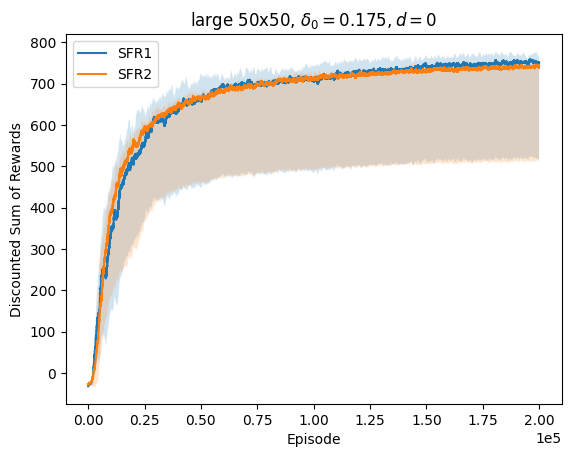

sf_reinforce_const_0.5 large
two_sided_sf_reinforce_const_0.5 large


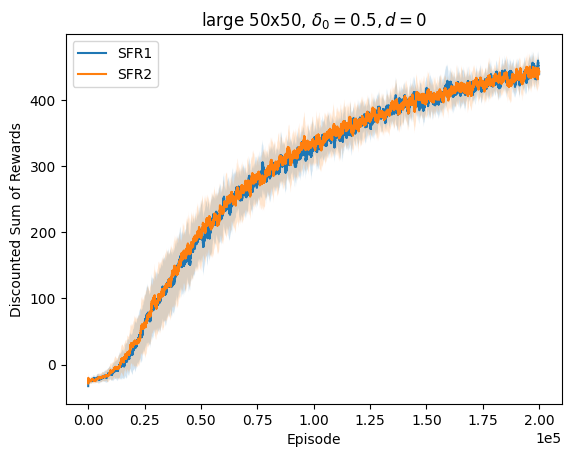

sf_reinforce_const_0.7 large
two_sided_sf_reinforce_const_0.7 large


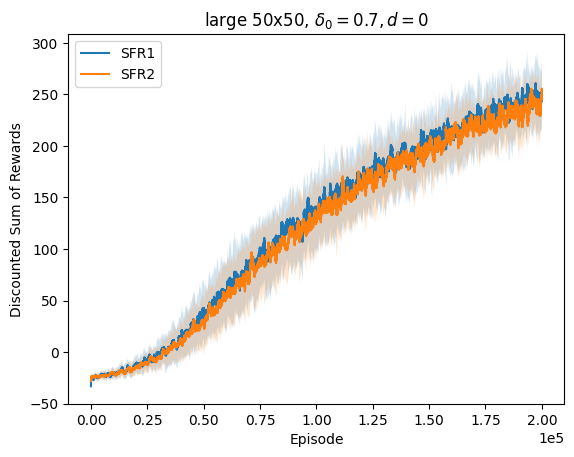

In [16]:
gridsizes = ["4x4", "8x8", "10x10", "20x20", "50x50"]
for grid, gridsize in zip(["large"], ["50x50"]):
    for suffix in "const_0.175 const_0.5 const_0.7".split():
        for algo in "sf_reinforce two_sided_sf_reinforce".split():
            name = algo + "_" + suffix
            dirname = os.path.join("saves", name, grid)
            filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
            path = os.path.join(dirname, filename)
            print(name, grid)
            avg_rewards, bot, top = get_results(path, 800)
            plt.plot(avg_rewards, label=to_paper_name(algo))
            plt.fill_between(range(len(avg_rewards)), bot, top, alpha=0.2)
        plt.title(f"{grid} {gridsize}, $\delta_0={suffix[6:]}, d=0$")
        plt.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
        plt.xlabel('Episode')
        plt.ylabel('Discounted Sum of Rewards')
        plt.legend()
        plt.savefig(f"images/sfr_large_{suffix}.png", bbox_inches="tight")
        plt.show()

## Signed

sf_reinforce_signed_const_0.175_start_alpha=0.02 large
two_sided_sf_reinforce_signed_const_0.175_start_alpha=0.02 large


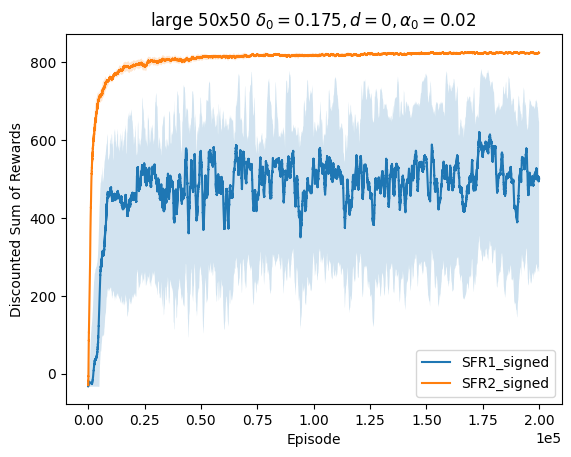

sf_reinforce_signed_const_delta=0.175_start_alpha=0.002 large
two_sided_sf_reinforce_signed_const_delta=0.175_start_alpha=0.002 large


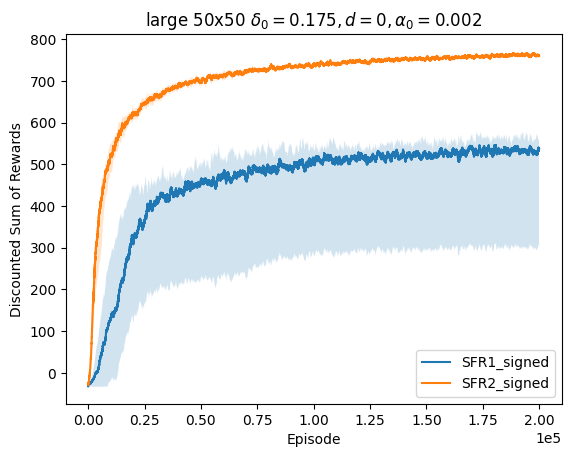

sf_reinforce_signed_const_0.175_start_alpha=0.0002 large
two_sided_sf_reinforce_signed_const_0.175_start_alpha=0.0002 large


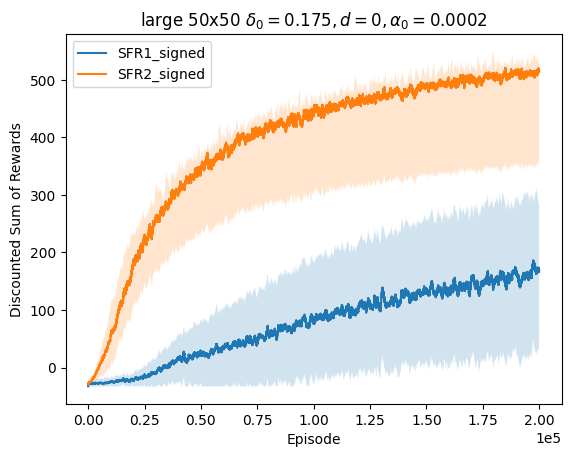

sf_reinforce_signed_const_0.175_start_alpha=2e-06 large
two_sided_sf_reinforce_signed_const_0.175_start_alpha=2e-06 large


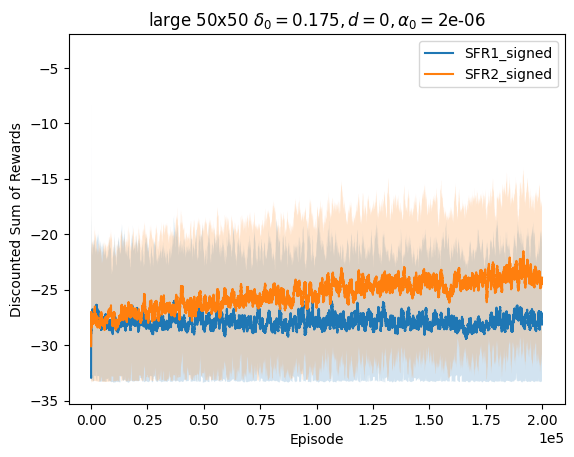

In [22]:
# mapping = dict(zip(['sf_reinforce_signed_const_0.175',
#  'sf_reinforce_signed_const_0.175_small_alpha',
#  'two_sided_sf_reinforce_signed_const_0.175',
#  'two_sided_sf_reinforce_signed_const_0.175_small_alpha'], ["sf_reinforce_signed_alpha_2e-4"]))
frame = []
for grid, gridsize in zip(["large"], ["50x50"]):
    for suffix in "const_0.175_start_alpha=0.02 const_delta=0.175_start_alpha=0.002 const_0.175_start_alpha=0.0002 const_0.175_start_alpha=2e-06".split():
        for algo in "sf_reinforce_signed two_sided_sf_reinforce_signed".split():
            name = algo + "_" + suffix
            dirname = os.path.join("saves", name, grid)
            filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
            path = os.path.join(dirname, filename)
            print(name, grid)
            avg_rewards, bot, top = get_results(path, 800)
            plt.plot(avg_rewards, label=to_paper_name(algo))
            plt.fill_between(range(len(avg_rewards)), bot, top, alpha=0.2)

            with open(path, "rb") as file:
                results = np.array(pickle.load(file))

            per_seed_results = results[:, -200:].mean(1)
            disp = f"{per_seed_results.mean():.2f} +- {per_seed_results.std():.1f}"
            frame.append((algo, suffix.split("_")[-2], disp))
        plt.title(f"{grid} {gridsize} $\delta_0=0.175, d=0, \\alpha_0=${suffix.split('=')[-1]}")
        plt.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
        plt.xlabel('Episode')
        plt.ylabel('Discounted Sum of Rewards')
        plt.legend()
        start_alpha = float(suffix.split('=')[-1])
        match start_alpha:
            case 2e-2:
                size = 'large'
            case 2e-3:
                size = 'medium_large'
            case 2e-4:
                size = 'medium'
            case 2e-6:
                size = 'small'
            case _:
                size = "none"
        plt.savefig(f"images/sfr_sgn_{size}.png", bbox_inches="tight")
        plt.show()

In [12]:
# frame = []
# for grid, gridsize in zip(["large"], ["50x50"]):
#     for suffix in "const_delta=0.175_start_alpha=0.02_grad_bound=1.5 const_delta=0.5_start_alpha=0.02_grad_bound=1.5".split():
#         for algo in "sf_reinforce two_sided_sf_reinforce".split():
#             name = algo + "_" + suffix
#             dirname = os.path.join("saves", name, grid)
#             filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
#             path = os.path.join(dirname, filename)
#             print(name, grid)
#             avg_rewards, bot, top = get_results(path, 800)
#             plt.plot(avg_rewards, label=name)
#             plt.fill_between(range(len(avg_rewards)), bot, top, alpha=0.2)

#             with open(path, "rb") as file:
#                 results = np.array(pickle.load(file))

#             per_seed_results = results[:, -200:].mean(1)
#             disp = f"{per_seed_results.mean():.2f} +- {per_seed_results.std():.1f}"
#             frame.append((name, suffix.split("_")[-2], disp))
#         plt.title(f"Gradient Clipping on 50x50 grid")
#         plt.xlabel('Episode')
#         plt.ylabel('Discounted Sum of Rewards')
#         plt.legend()
#         plt.show()

# frame = pd.DataFrame(frame).pivot(index=0, columns=1).reset_index()
# frame.columns = ["Algorithm / Decay"] + [col for _, col in frame.columns][1:]
# # frame = frame_sgn.merge(frame, on="Algorithm / Decay")
# display(frame)
# print(
#     frame
#     .to_latex(index=False, escape=True)
#     .replace("toprule", "hline")
#     .replace("bottomrule", "hline")
#     .replace("midrule", "hline")
#     .replace("+-", "$\\pm$")
# )

## Aggregate results and plots

### Experiment names

In [23]:
def get_exp_name(conf):
    if 'grad_bound' in conf:
        return 'grad_clip'
    if 'grad_norm' in conf:
        return 'grad_norm'
    if 'signed' in conf:
        return 'signed'
    if 'const' in conf:
        return 'const_delta'
    return 'vanilla'

large_exp = []
exp: str
for exp in os.listdir("saves"):
    if 'large' in os.listdir(f"saves/{exp}"):
        dirname = os.path.join('saves', exp, 'large')
        filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
        path = os.path.join(dirname, filename)
        with open(path, "rb") as file:
            results = np.array(pickle.load(file))

        algo = (
            'sf_reinforce' if exp.startswith('sf_reinforce')
            else 'two_sided_sf_reinforce' if exp.startswith('two_sided_sf_reinforce')
            else "ppo" if exp.startswith("ppo")
            else 'reinforce'
        )
        if exp =="bpo_old":
            continue
        per_seed_results = results[:, -200:].mean(1)
        mean, std = pd.Series(per_seed_results).mean().round(2), per_seed_results.std().round(1)
        disp = f"{mean} +- {std}"
        large_exp.append([algo, mean, std, exp, disp])
df = pd.DataFrame(large_exp, columns=["algo", 'mean', 'std', 'conf', 'disp'])
# df = df[df['mean'] > -20]

df['exp'] = df.conf.apply(get_exp_name)
df = df.sort_values(["algo", "exp", 'mean', 'std'], ignore_index=True)
display(df)
df_last = df.groupby(["algo", "exp"]).last()
display(df_last.groupby(["exp", "algo"]).last().drop(['conf', 'disp'], axis=1))
display(df_last.drop(['conf', 'disp'], axis=1))
df_last = df_last.reset_index()

,algo,mean,std,conf,disp,exp
0,ppo,-41.83,2.0,ppo_old,-41.83 +- 2.0,vanilla
1,reinforce,-18.79,8.4,reinforce,-18.79 +- 8.4,vanilla
2,sf_reinforce,254.74,35.6,sf_reinforce_const_0.7,254.74 +- 35.6,const_delta
3,sf_reinforce,446.65,26.8,sf_reinforce_const_0.5,446.65 +- 26.8,const_delta
4,sf_reinforce,677.55,233.1,sf_reinforce_const_0.175,677.55 +- 233.1,const_delta
5,sf_reinforce,437.06,293.6,sf_reinforce_const_delta=0.175_start_alpha=0.0...,437.06 +- 293.6,grad_clip
6,sf_reinforce,483.68,215.3,sf_reinforce_const_delta=0.5_start_alpha=0.02_...,483.68 +- 215.3,grad_clip
7,sf_reinforce,-25.25,6.5,sf_reinforce_const_delta=0.175_grad_norm=5.0,-25.25 +- 6.5,grad_norm
8,sf_reinforce,-23.18,5.2,sf_reinforce_const_delta=0.5_grad_norm=5.0,-23.18 +- 5.2,grad_norm
9,sf_reinforce,-22.34,6.8,sf_reinforce_const_delta=0.5_grad_norm=50.0,-22.34 +- 6.8,grad_norm


mean    std
exp         algo                                 
const_delta sf_reinforce            677.55  233.1
            two_sided_sf_reinforce  665.50  229.1
grad_clip   sf_reinforce            483.68  215.3
            two_sided_sf_reinforce  824.96    5.6
grad_norm   sf_reinforce            395.38  279.6
            two_sided_sf_reinforce  830.40    3.7
signed      sf_reinforce            424.93  254.5
            two_sided_sf_reinforce  823.68    3.1
vanilla     ppo                     -41.83    2.0
            reinforce               -18.79    8.4
            sf_reinforce            376.29  401.4
            two_sided_sf_reinforce  562.89  387.7

mean    std
algo                   exp                       
ppo                    vanilla      -41.83    2.0
reinforce              vanilla      -18.79    8.4
sf_reinforce           const_delta  677.55  233.1
                       grad_clip    483.68  215.3
                       grad_norm    395.38  279.6
                       signed       424.93  254.5
                       vanilla      376.29  401.4
two_sided_sf_reinforce const_delta  665.50  229.1
                       grad_clip    824.96    5.6
                       grad_norm    830.40    3.7
                       signed       823.68    3.1
                       vanilla      562.89  387.7

- Two sided 
    -   both gradient clipping and signed updates are great for reducing std and improving performance
- One sided
    - const delta is great, but since the gradient updated is one sided, there will be inherent noise in the distribtuion.
    - Need to try normed updates.

In [24]:
frame = df_last.drop(["conf", "mean", "std"], axis=1).round(2).pivot(index="algo", columns="exp", values="disp")
frame = frame[["vanilla", "const_delta", "signed", "grad_clip", "grad_norm"]].reset_index().fillna("-")
display(frame)
print(frame.columns)
# frame["mean"] = frame["mean"].apply(lambda x: f"{x:.2f}")
# frame["std"] = frame["std"].apply(lambda x: f"{x:.1f}")

print(
    frame.to_latex(index=False, escape=True)
    .replace("toprule", "hline")
    .replace("bottomrule", "hline")
    .replace("midrule", "hline")
    .replace("+-", "$\\pm$")
)

exp,algo,vanilla,const_delta,signed,grad_clip,grad_norm
0,ppo,-41.83 +- 2.0,-,-,-,-
1,reinforce,-18.79 +- 8.4,-,-,-,-
2,sf_reinforce,376.29 +- 401.4,677.55 +- 233.1,424.93 +- 254.5,483.68 +- 215.3,395.38 +- 279.6
3,two_sided_sf_reinforce,562.89 +- 387.7,665.5 +- 229.1,823.68 +- 3.1,824.96 +- 5.6,830.4 +- 3.7


Index(['algo', 'vanilla', 'const_delta', 'signed', 'grad_clip', 'grad_norm'], dtype='object', name='exp')


\begin{tabular}{llllll}
\hline
algo & vanilla & const\_delta & signed & grad\_clip & grad\_norm \\
\hline
ppo & -41.83 $\pm$ 2.0 & - & - & - & - \\
reinforce & -18.79 $\pm$ 8.4 & - & - & - & - \\
sf\_reinforce & 376.29 $\pm$ 401.4 & 677.55 $\pm$ 233.1 & 424.93 $\pm$ 254.5 & 483.68 $\pm$ 215.3 & 395.38 $\pm$ 279.6 \\
two\_sided\_sf\_reinforce & 562.89 $\pm$ 387.7 & 665.5 $\pm$ 229.1 & 823.68 $\pm$ 3.1 & 824.96 $\pm$ 5.6 & 830.4 $\pm$ 3.7 \\
\hline
\end{tabular}



In [25]:
pd.set_option('display.max_colwidth', None)
df_last[df_last.exp.str.contains('grad')]

,algo,exp,mean,std,conf,disp
3,sf_reinforce,grad_clip,483.68,215.3,sf_reinforce_const_delta=0.5_start_alpha=0.02_grad_bound=1.5,483.68 +- 215.3
4,sf_reinforce,grad_norm,395.38,279.6,sf_reinforce_const_delta=0.175_start_alpha=0.0002_grad_norm=50.0,395.38 +- 279.6
8,two_sided_sf_reinforce,grad_clip,824.96,5.6,two_sided_sf_reinforce_const_delta=0.175_start_alpha=0.02_grad_bound=1.5,824.96 +- 5.6
9,two_sided_sf_reinforce,grad_norm,830.40,3.7,two_sided_sf_reinforce_const_delta=0.175_start_alpha=0.02_grad_norm=5.0,830.4 +- 3.7


In [26]:
sgn = df.loc[df.exp.str.contains("signed"), ["algo", "conf", "disp"]].reset_index(
    drop=True
)
sgn["conf"] = sgn.conf.apply(lambda x: x.split("_")[-1])
sgn = sgn.pivot(index="algo", columns="conf", values="disp").reset_index()
print(
    sgn.to_latex(index=False, escape=True)
    .replace("toprule", "hline")
    .replace("bottomrule", "hline")
    .replace("midrule", "hline")
    .replace("+-", "$\\pm$")
)

\begin{tabular}{lllll}
\hline
algo & alpha=0.0002 & alpha=0.002 & alpha=0.02 & alpha=2e-06 \\
\hline
sf\_reinforce & 141.32 $\pm$ 144.6 & 392.66 $\pm$ 234.3 & 424.93 $\pm$ 254.5 & -26.03 $\pm$ 8.2 \\
two\_sided\_sf\_reinforce & 456.54 $\pm$ 161.1 & 761.28 $\pm$ 6.7 & 823.68 $\pm$ 3.1 & -22.87 $\pm$ 6.4 \\
\hline
\end{tabular}



In [27]:
print(df_last.drop(['conf', 'disp'], axis=1).round(2).to_latex(index=False, escape=True)
    .replace("toprule", "hline")
    .replace("bottomrule", "hline")
    .replace("midrule", "hline")
    .replace("+-", "$\\pm$"))

\begin{tabular}{llrr}
\hline
algo & exp & mean & std \\
\hline
ppo & vanilla & -41.830000 & 2.000000 \\
reinforce & vanilla & -18.790000 & 8.400000 \\
sf\_reinforce & const\_delta & 677.550000 & 233.100000 \\
sf\_reinforce & grad\_clip & 483.680000 & 215.300000 \\
sf\_reinforce & grad\_norm & 395.380000 & 279.600000 \\
sf\_reinforce & signed & 424.930000 & 254.500000 \\
sf\_reinforce & vanilla & 376.290000 & 401.400000 \\
two\_sided\_sf\_reinforce & const\_delta & 665.500000 & 229.100000 \\
two\_sided\_sf\_reinforce & grad\_clip & 824.960000 & 5.600000 \\
two\_sided\_sf\_reinforce & grad\_norm & 830.400000 & 3.700000 \\
two\_sided\_sf\_reinforce & signed & 823.680000 & 3.100000 \\
two\_sided\_sf\_reinforce & vanilla & 562.890000 & 387.700000 \\
\hline
\end{tabular}



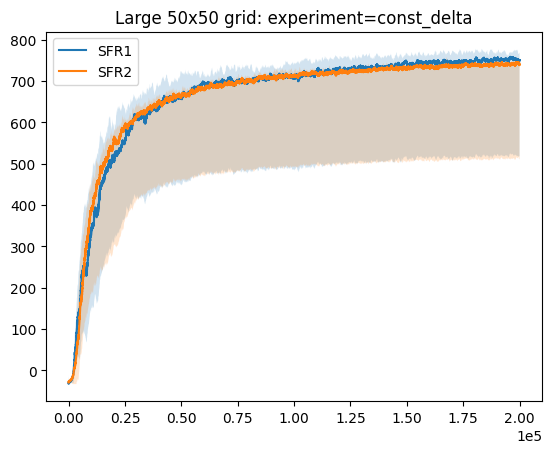

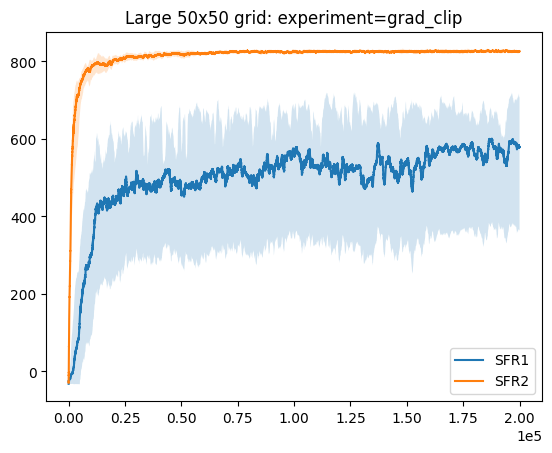

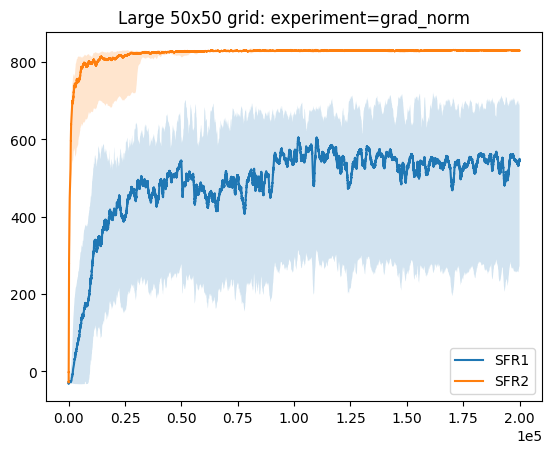

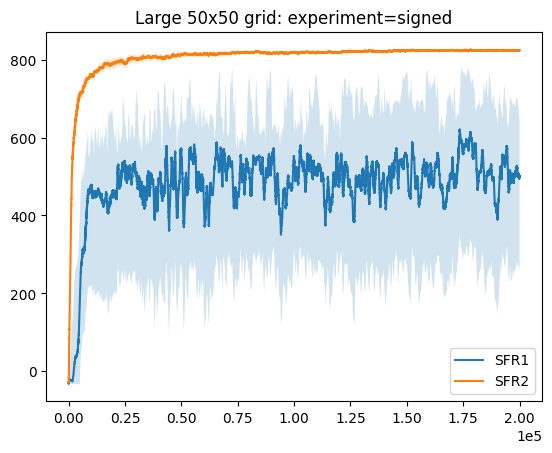

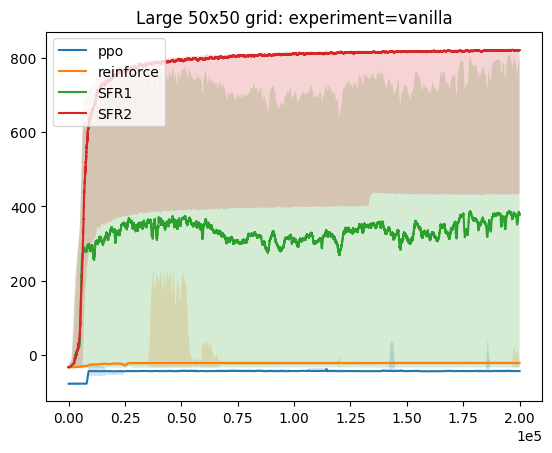

In [29]:
for exp, item in df_last.groupby("exp"):
    for row in item.itertuples():
        dirname = os.path.join("saves", row.conf, "large")
        filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
        path = os.path.join(dirname, filename)
        avg_rewards, bot, top = get_results(path, 800)
        plt.plot(avg_rewards, label=to_paper_name(row.algo))
        plt.fill_between(range(len(avg_rewards)), bot, top, alpha=0.2)
    plt.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    plt.title(f"Large 50x50 grid: experiment={exp}")
    plt.legend()
    plt.savefig(f"images/{exp}.png", bbox_inches="tight")
    plt.show()

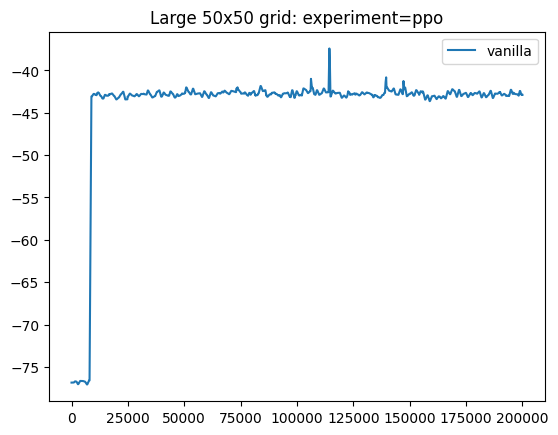

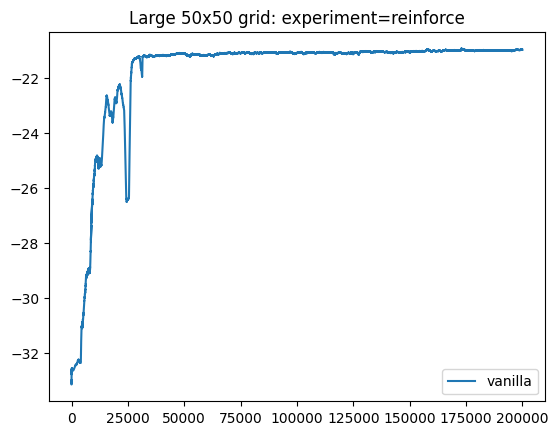

/data/home/deepakh/miniconda3/envs/py311/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


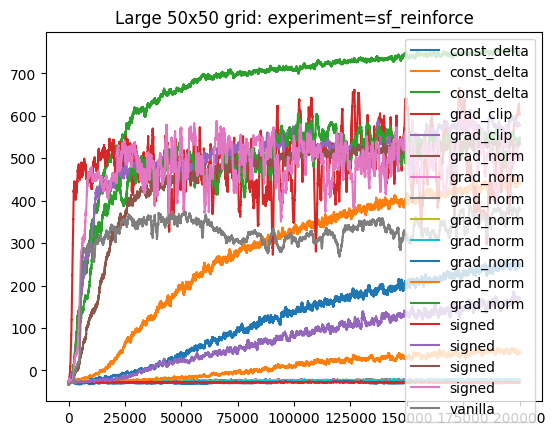

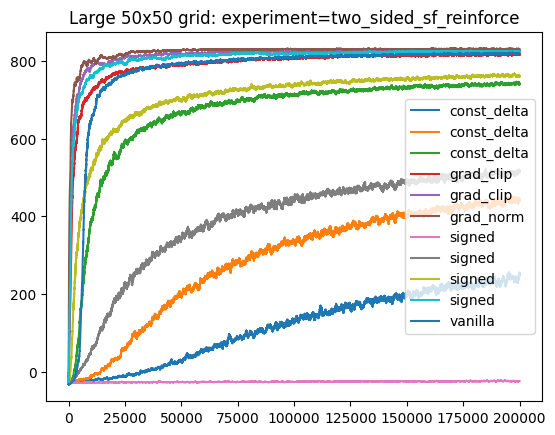

In [31]:
for algo, item in df.groupby("algo"):
    for row in item.itertuples():
        dirname = os.path.join("saves", row.conf, "large")
        filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
        path = os.path.join(dirname, filename)
        avg_rewards, bot, top = get_results(path, 800)
        plt.plot(avg_rewards, label=row.exp)
        # plt.fill_between(range(len(avg_rewards)), bot, top, alpha=0.1)
    plt.title(f"Large 50x50 grid: experiment={algo}")
    plt.legend()
    plt.show()

In [22]:
from network import PolicyNetwork

model=PolicyNetwork(4, 50)

for param in model.parameters():
    print(param.shape)

torch.Size([4, 6])
torch.Size([4])


In [ ]:
for algo, item in df.groupby("algo"):
    for row in item.itertuples():
        dirname = os.path.join("saves", row.conf, "large")
        filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
        path = os.path.join(dirname, filename)
        avg_rewards, bot, top = get_results(path, 800)
        plt.plot(avg_rewards, label=row.exp)
        # plt.fill_between(range(len(avg_rewards)), bot, top, alpha=0.1)
    plt.title(f"Large 50x50 grid: experiment={algo}")
    plt.legend()
    plt.show()